In [10]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, Conv2D, Conv2DTranspose, Lambda, BatchNormalization
#from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import numpy as np
import msprime
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap
from tempfile import TemporaryFile

In [2]:
#outputfile = TemporaryFile()
#x = np.arange(10)
#np.save(outputfile, x)
#_ = outputfile.seek(0)
#np.load(outputfile)

# <center> Variational Autoencoder </center>

In [13]:
# To sort the genotype matrices

from sklearn.neighbors import NearestNeighbors
def sort_min_diff(amat):
    '''this function takes in a SNP matrix with indv on rows and returns the same 
    matrix with indvs sorted by genetic similarity.this problem is NP, so here we 
    use a nearest neighbors approx.  it's not perfect, but it's fast and generally performs ok.
    assumes your input matrix is a numpy array'''
    mb = NearestNeighbors(len(amat), metric='manhattan').fit(amat)
    v = mb.kneighbors(amat)
    smallest = np.argmin(v[0].sum(axis=1))
    return amat[v[1][smallest]]

In [12]:
# Simulates the genotype matrices

def simulations(range_=10000, img_dim=64):
    
    gene_list = []
    resized_img = []
    rr_min, rr_max = 1e-7, 1e-9
    rr = np.random.uniform(rr_min, rr_max, size=range_)
    
    for i in range(range_):
        i = msprime.simulate(sample_size=100, Ne=10000, length=1e5, mutation_rate=1e-8, recombination_rate=rr[i])
        gene_list.append(np.array(i.genotype_matrix(), dtype=float))
    
    for i in gene_list:
        resized_img.append(resize(sort_min_diff(sort_min_diff(i.T).T).T, (img_dim, img_dim), preserve_range=True))
    
    return np.asarray(resized_img), rr, rr_min, rr_max

In [14]:
# Call's the simulation function

img_data, rr, rr_min, rr_max = simulations(range_=10000, img_dim=32)

In [15]:
# To split the data into train, test and validation data

def data_split(data, rec_rate):
    
    x_train = data[:int(len(data) * 0.7)]
    x_test = data[int(len(data) * 0.7):int(len(data) * 0.85)]
    x_val = data[int(len(data) * 0.85):]
    
    # Corresponding to x_test data
    rr_test = rec_rate[int(len(rec_rate) * 0.7):int(len(rec_rate) * 0.85)]
    
    return x_train, x_test, x_val, rr_test

In [16]:
# Call's the data_split function

x_train, x_test, x_val, rr_test = data_split(img_data, rr)

In [17]:
# Flattening of the images

x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_val = x_val.reshape(len(x_val), np.prod(x_val.shape[1:]))

In [42]:
# Parameters

img_size = 32
original_dim = img_size * img_size
latent_dim = 300

In [20]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(latent_dim,))
    return z_mean + K.exp(z_log_std) * epsilon

In [21]:
def vae_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.square(x - x_decoded_mean), axis=-1), axis=-1)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss

In [168]:
# Encoder

x = Input(shape=(original_dim,))
h = Dense(3 * latent_dim, activation='relu')(x)
h = Dense(2 * latent_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

# Sampling

z = Lambda(sampling)([z_mean, z_log_std])

# Decoder

#d_h = Dense(2 * latent_dim, activation='relu')(z)
#d_h = Dense(3 * latent_dim, activation='relu')(d_h)
#d_mean = Dense(original_dim, activation='sigmoid')(d_h)
decoder_h1 = Dense(2 * latent_dim, activation='relu')
decoder_h2 = Dense(3 * latent_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h1_decoded = decoder_h1(z)
h2_decoded = decoder_h2(h1_decoded)
x_decoded_mean = decoder_mean(h2_decoded)

In [169]:
# Instansiate models

encoder = Model(x, z_mean)
vae = Model(x, x_decoded_mean)

In [170]:
#decoder_input = Input(shape=(latent_dim,))
#h_decoded = d_h(decoder_input)
#x_decoded_mean = d_mean(h_decoded)
#generator = Model(decoder_input, x_decoded_mean)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h1(decoder_input)
_h1_decoded = decoder_h2(_h_decoded)
_x_decoded_mean = decoder_mean(_h1_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [171]:
# Compile the vae

vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False, metrics=['accuracy'])

In [172]:
his = vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=128,
        validation_data=(x_val, x_val))

Train on 7000 samples, validate on 1500 samples
Epoch 1/50
7000/7000 [==============================] - 11s 2ms/sample - loss: 21.7474 - accuracy: 0.1274 - val_loss: 11.2787 - val_accuracy: 0.3413
Epoch 2/50
7000/7000 [==============================] - 8s 1ms/sample - loss: 9.2717 - accuracy: 0.3320 - val_loss: 10.5232 - val_accuracy: 0.3400
Epoch 3/50
7000/7000 [==============================] - 8s 1ms/sample - loss: 9.2815 - accuracy: 0.3050 - val_loss: 10.1262 - val_accuracy: 0.2807
Epoch 4/50
7000/7000 [==============================] - 8s 1ms/sample - loss: 9.3905 - accuracy: 0.3100 - val_loss: 9.4740 - val_accuracy: 0.3593
Epoch 5/50
7000/7000 [==============================] - 9s 1ms/sample - loss: 9.1463 - accuracy: 0.3357 - val_loss: 9.0644 - val_accuracy: 0.3593
Epoch 6/50
7000/7000 [==============================] - 8s 1ms/sample - loss: 8.6510 - accuracy: 0.3446 - val_loss: 9.3698 - val_accuracy: 0.3500
Epoch 7/50
7000/7000 [==============================] - 8s 1ms/sample -

In [173]:
def plot_loss(loss, val_loss, accuracy, val_accuracy):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    plt.subplot(122)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

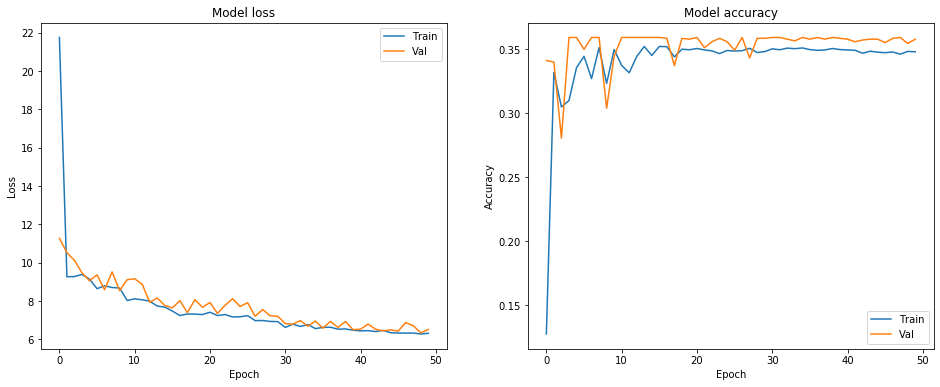

In [174]:
plot_loss(his.history['loss'], his.history['val_loss'], his.history['accuracy'], his.history['val_accuracy'])

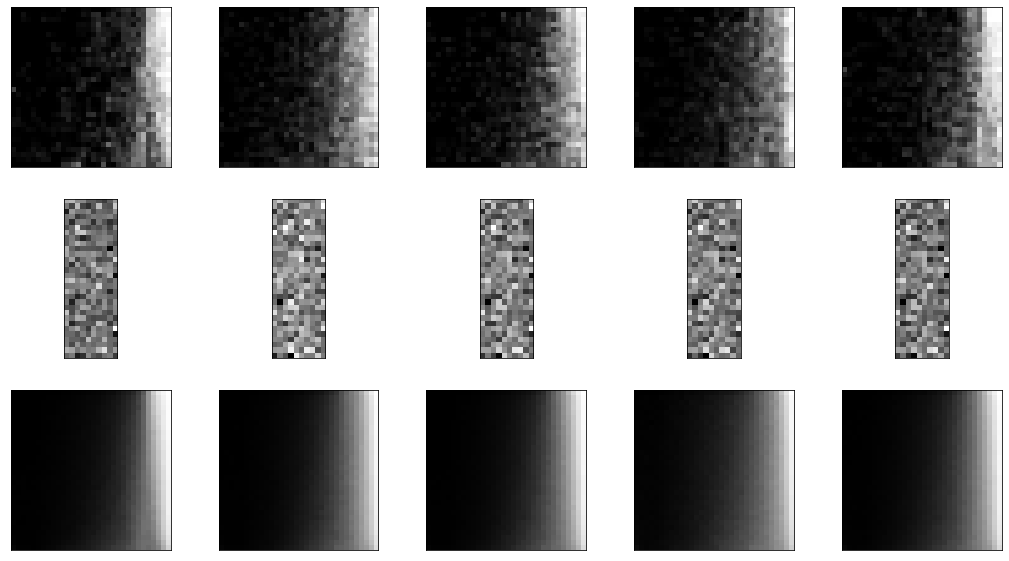

In [175]:
num_images = 5
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test)

plt.figure(figsize=(18, 10))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(30, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(encoded_imgs)

In [54]:
reducer = umap.UMAP()
umap_ = reducer.fit_transform(encoded_imgs)

In [50]:
low = np.argmin(rr)

In [51]:
high = np.argmax(rr)

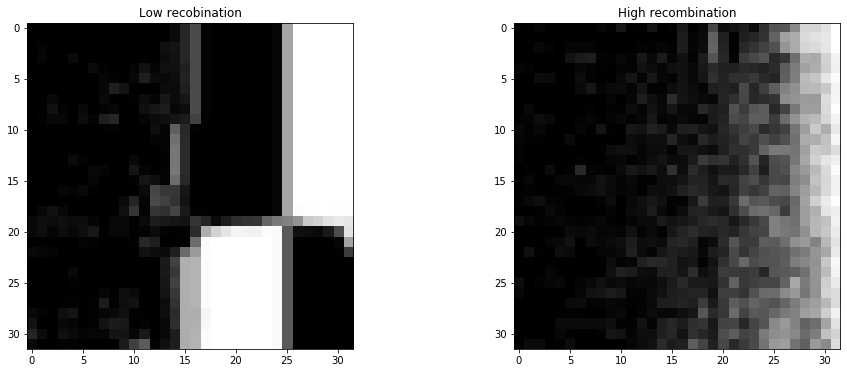

In [176]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Low recobination')
plt.imshow(img_data[low])

plt.subplot(122)
plt.title('High recombination')
plt.imshow(img_data[high])
plt.show()

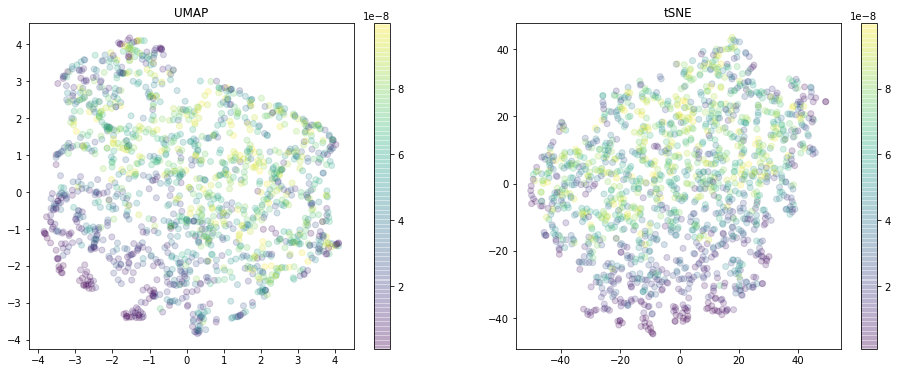

In [55]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.scatter(umap_[:,0], umap_[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('UMAP')
plt.colorbar()

plt.subplot(122)
plt.scatter(x_tsne[:,0], x_tsne[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('tSNE')
plt.colorbar()
plt.show()

In [84]:
low_test = np.argmin(rr_test)

In [85]:
high_test = np.argmax(rr_test)

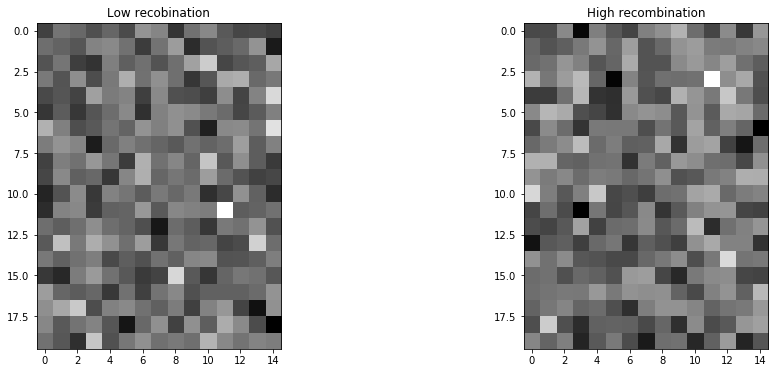

In [86]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Low recobination')
plt.imshow(encoded_imgs[low_test].reshape(20, 15))

plt.subplot(122)
plt.title('High recombination')
plt.imshow(encoded_imgs[high_test].reshape(20, 15))
plt.show()

In [109]:
len(encoded_imgs)

1500

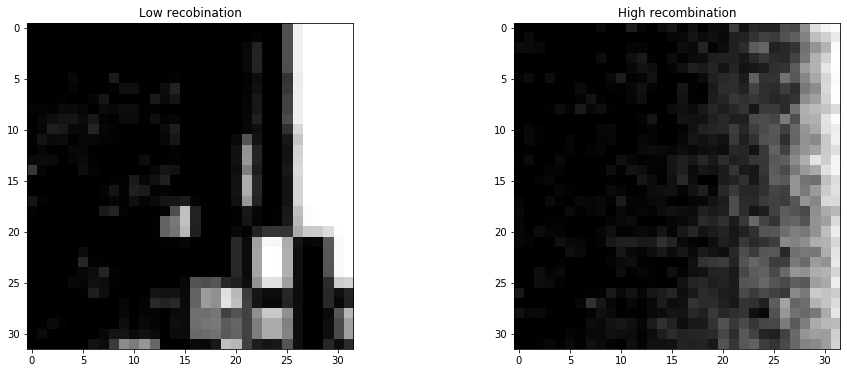

In [135]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Low recobination')
plt.imshow(x_test[low_test].reshape(32, 32))

plt.subplot(122)
plt.title('High recombination')
plt.imshow(x_test[high_test].reshape(32, 32))
plt.show()

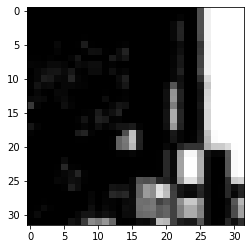

In [107]:
plt.imshow(x_test[low_test].reshape(32, 32))
plt.show()

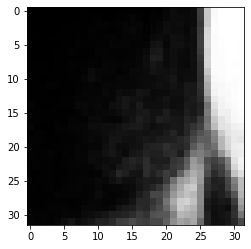

In [131]:
plt.imshow(decoded_imgs[low_test].reshape(32, 32))
plt.show()

In [136]:
X = encoded_imgs[low_test] - encoded_imgs[high_test]

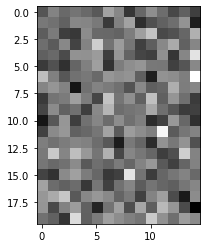

In [137]:
plt.imshow(X.reshape(20, 15))
plt.show()

In [177]:
bla = encoder.predict(x_test)

In [178]:
bla2 = vae.predict(x_test)

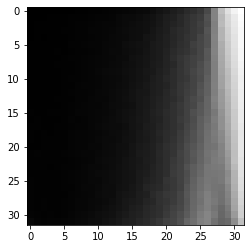

In [179]:
plt.imshow(bla2[1].reshape(32, 32))
plt.show()

In [183]:
bla3 = generator.predict(X.reshape(1, 300))

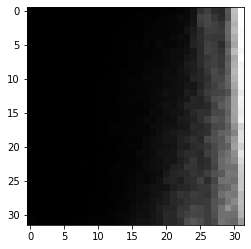

In [185]:
plt.imshow(bla3[0].reshape(32, 32))
plt.show()